<a href="https://colab.research.google.com/github/umd-fire-coml/2022-t3-vector-quantization/blob/model_commit_2/VQ_VAE_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q tensorflow-probability


ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/comm

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf


In [4]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


In [5]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(140,1, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [6]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(140,1, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 140, 1, 1)]       0         
                                                                 
 encoder (Functional)        (None, 35, 1, 16)         19856     
                                                                 
 vector_quantizer (VectorQua  (None, 35, 1, 16)        1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 140, 4, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


In [7]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [8]:
!git clone https://github.com/mdeff/fma.git


Cloning into 'fma'...
remote: Enumerating objects: 823, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 823 (delta 6), reused 10 (delta 3), pack-reused 808
Receiving objects: 100% (823/823), 4.08 MiB | 10.53 MiB/s, done.
Resolving deltas: 100% (528/528), done.


In [9]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  10.1M      0  0:00:33  0:00:33 --:--:-- 11.5M


In [10]:
!echo "f0df49ffe5f2a6008d7dc83c6915b31835dfe733  fma_metadata.zip" | sha1sum -c -
!7z e fma_metadata.zip

fma_metadata.zip: OK

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 358412441 bytes (342 MiB)

Extracting archive: fma_metadata.zip
--
Path = fma_metadata.zip
Type = zip
Physical Size = 358412441

  0%      0% 4 - fma_metadata/raw_albums.csv                                      1% 4 - fma_metadata/raw_albums.csv                                      1% 5        1% 5 - fma_metadata/raw_artists.csv                                       2% 5 - fma_metadata/raw_artists.csv                         

In [11]:
cd fma

/content/fma


In [12]:
!pip install py7zr
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 163 kB/s 
     |████████████████████████████████| 2.3 MB 9.0 MB/s 
     |████████████████████████████████| 139 kB 51.6 MB/s 
     |████████████████████████████████| 357 kB 33.5 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 378 kB 42.1 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import time
import os

import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

import utils

In [14]:
cd ..

/content


In [15]:
tracks = utils.load('tracks.csv')
features = utils.load('features.csv')
echonest = utils.load('echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

((106574, 52), (106574, 518), (13129, 249))

In [22]:
print(features['mfcc'].shape)


(106574, 140)


In [17]:
import numpy as np

print(np.newaxis is None)


True


In [19]:
x_train = features['mfcc'].to_numpy()
x_test = features['mfcc'].to_numpy()

In [26]:
x_train = x_train[1:80001,]
x_test = x_train[80001:106575,]

In [20]:

x_train = np.expand_dims(x_train, -1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

x_train.shape, x_test.shape


((106574, 140, 1, 1), (106574, 140, 1, 1))

In [28]:
mkdir ecpoch_data

In [37]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

#from keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('/ecpoch_data' , save_freq = 'epoch', 
 #                            save_weights_only = False)
#build(x_train.shape)
#vqvae_trainer.call()
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128) #, callbacks = [checkpoint])


Epoch 1/30
833/833 [==============================] - 123s 145ms/step - loss: 3.9888 - reconstruction_loss: 0.4403 - vqvae_loss: 3.0393
Epoch 2/30
833/833 [==============================] - 122s 147ms/step - loss: 1.2014 - reconstruction_loss: 0.1327 - vqvae_loss: 1.0431
Epoch 3/30
833/833 [==============================] - 121s 146ms/step - loss: 0.4385 - reconstruction_loss: 0.0790 - vqvae_loss: 0.3535
Epoch 4/30
833/833 [==============================] - 120s 145ms/step - loss: 0.2901 - reconstruction_loss: 0.0653 - vqvae_loss: 0.2218
Epoch 5/30
833/833 [==============================] - 122s 146ms/step - loss: 0.1849 - reconstruction_loss: 0.0428 - vqvae_loss: 0.1351
Epoch 6/30
833/833 [==============================] - 118s 142ms/step - loss: 0.1170 - reconstruction_loss: 0.0348 - vqvae_loss: 0.0817
Epoch 7/30
833/833 [==============================] - 121s 145ms/step - loss: 0.1116 - reconstruction_loss: 0.0287 - vqvae_loss: 0.0820
Epoch 8/30
833/833 [============================

In [38]:
trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

#for test_image, reconstructed_image in zip(test_images, reconstructions_test):
 #   print(test_image)
  #  print(reconstructed_image)

1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 81ms/step


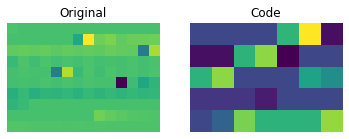

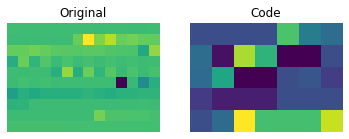

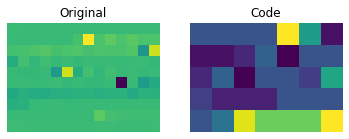

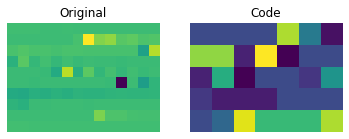

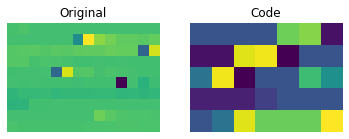

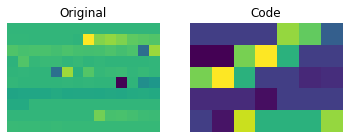

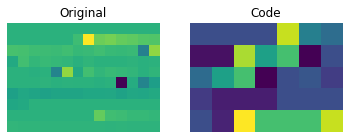

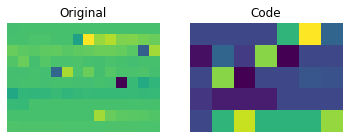

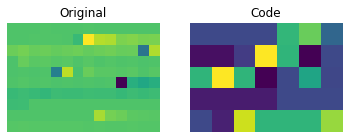

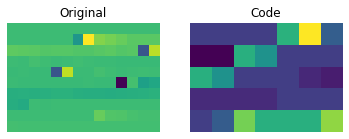

In [39]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].reshape(10,14))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i].reshape(5,7))
    plt.title("Code")
    plt.axis("off")
    plt.show()


In [40]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")


Input shape of the PixelCNN: (35, 1)


In [41]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()


Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 35, 1)]           0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 35, 1, 128)        0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 35, 1, 128)       802944    
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 35, 1, 128)       98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 35, 1, 128)       98624     
 lock)                                                           
                                                         

In [42]:
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")


3331/3331 [==============================] - 15s 5ms/step
Shape of the training data for PixelCNN: (106574, 35, 1)


In [43]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=30,
    validation_split=0.1,
)


Epoch 1/30
750/750 [==============================] - 425s 565ms/step - loss: 1.2712 - accuracy: 0.6367 - val_loss: 0.7528 - val_accuracy: 0.7152
Epoch 2/30
750/750 [==============================] - 429s 572ms/step - loss: 0.7003 - accuracy: 0.7340 - val_loss: 0.6865 - val_accuracy: 0.7402
Epoch 3/30
750/750 [==============================] - 424s 566ms/step - loss: 0.6568 - accuracy: 0.7469 - val_loss: 0.6609 - val_accuracy: 0.7427
Epoch 4/30
750/750 [==============================] - 417s 556ms/step - loss: 0.6385 - accuracy: 0.7513 - val_loss: 0.6480 - val_accuracy: 0.7485
Epoch 5/30
750/750 [==============================] - 420s 560ms/step - loss: 0.6289 - accuracy: 0.7535 - val_loss: 0.6402 - val_accuracy: 0.7471
Epoch 6/30
750/750 [==============================] - 423s 564ms/step - loss: 0.6229 - accuracy: 0.7547 - val_loss: 0.6330 - val_accuracy: 0.7528
Epoch 7/30
750/750 [==============================] - 416s 554ms/step - loss: 0.6197 - accuracy: 0.7553 - val_loss: 0.6315 -

KeyboardInterrupt: ignored

In [44]:
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)


In [45]:
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")


1/1 [==============================] - 0s 39ms/step
Prior shape: (10, 35, 1)


1/1 [==============================] - 0s 327ms/step


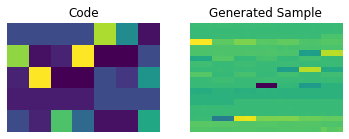

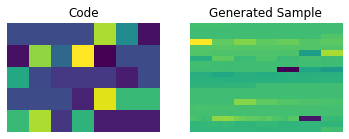

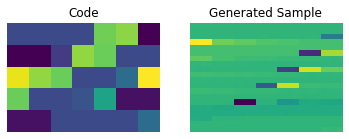

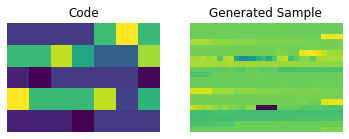

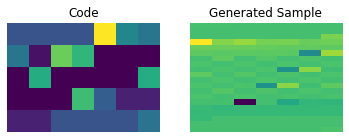

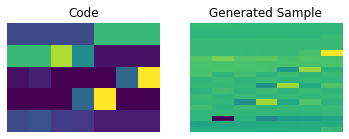

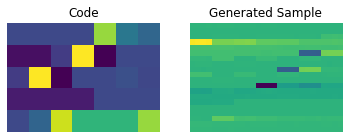

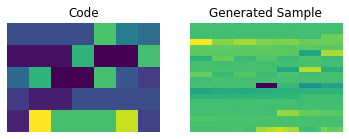

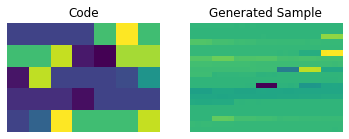

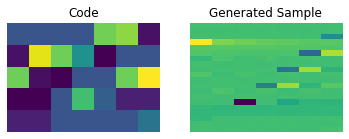

In [46]:
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i].reshape(5,7))
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].reshape(20,28))
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()




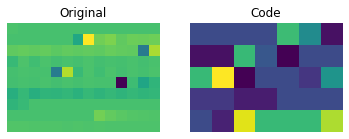

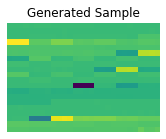

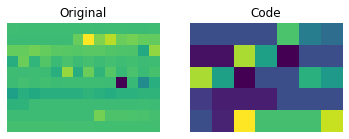

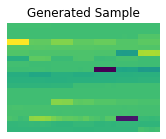

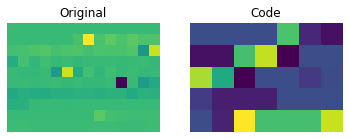

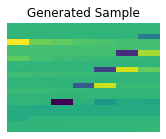

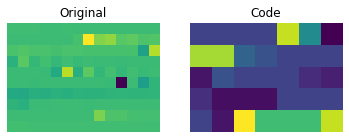

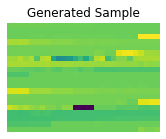

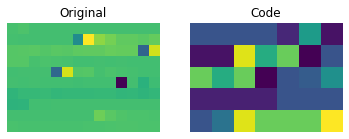

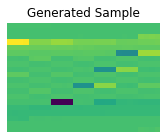

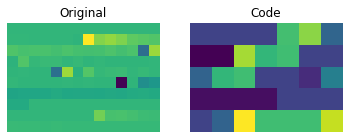

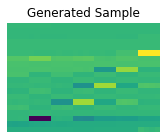

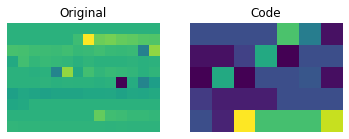

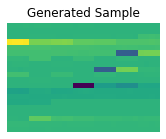

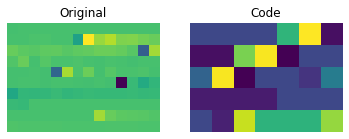

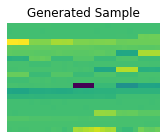

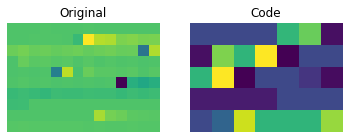

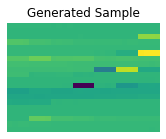

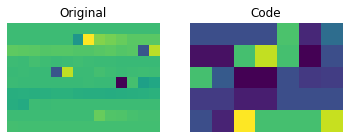

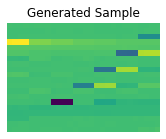

In [47]:
for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].reshape(10,14))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i].reshape(5,7))
    plt.title("Code")
    plt.axis("off")
    plt.show()

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].reshape(20,28))
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()


    


In [48]:
librosa.feature.inverse.mfcc_to_audio(generated_samples[0].squeeze())


NameError: ignored